## Real World

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, KFold

## OOB Method

In [12]:
def power_RW_OOB(n,B=250):
        
   np.random.seed(42)
   esperances = []
   variances = []
   test_statistics = []
   test_alternative = []
   power = []
   epsilon = np.random.normal(0, 1, n)
   x = np.random.uniform(0, 5, n)
   beta1 = 2
   beta2_values = np.linspace(0, 0.16, 9)

   bootstrap_indices = np.random.choice(n, size=(B, n), replace=True) # bootstrapping

   for beta2 in beta2_values:
       
       y = beta1 * x + beta2 * x**2 + epsilon # generation de données
       db = []
       
       for bootstrap_index in bootstrap_indices:
       
          x_train = x[bootstrap_index]
          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon[bootstrap_index]

          mask = np.ones(len(x), dtype=bool)
          mask[bootstrap_index] = False

          x_test = x[mask]
          y_test = y[mask]

          x_train_reshape = x_train.reshape(-1, 1)
          x_test_reshape = x_test.reshape(-1,1)

          model_a1 = LinearRegression().fit(x_train_reshape, y_train) # Modèle linéaire
          y_pred_a1 = model_a1.predict(x_test_reshape.reshape(-1,1))
          p1b = mean_squared_error(y_test, y_pred_a1)

          x_train_quad = np.column_stack((x_train_reshape, x_train**2))
          x_test_quad = np.column_stack((x_test_reshape, x_test**2))


          model_a2 = LinearRegression().fit(x_train_quad, y_train)
          y_pred_a2 = model_a2.predict(x_test_quad)
          p2b = mean_squared_error(y_test, y_pred_a2)

          db.append(p1b - p2b)  # Différence des moyennes de performance sur chaque bootstrap

       # Fin du boostrapping

       d_barre = sum(db)/B # Converge p.s vers l'espérance mu

       var = np.var(db, ddof=1)
       test_stat = (B**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle

       delta = d_barre
       student = stats.t.ppf(0.95, df=B-1)
       mu = (B ** 0.5)*delta/np.sqrt(var)
       test_alt = student - mu
       puissance = 1 - stats.norm.cdf(student - mu, 0, 1)
       
       esperances.append(d_barre)
       variances.append(var)
       test_statistics.append(test_stat)
       test_alternative.append(test_alt)
       power.append(puissance)

   return esperances, variances, test_statistics, test_alternative, power


In [13]:
esperances, variances, test_statistics, test_alternative, power = power_RW_OOB(n=150, B=250)
print(f"Espérances: {esperances}")
print(f"Variances: {variances}")
print(f"Statistiques de test: {test_statistics}")
print(f"Test alternative: {test_alternative}")
print(f"Puissance: {power}")


Espérances: [-0.014451267373026825, -0.012476367803492148, -0.00740440914527243, 0.0007646086016322342, 0.012030685437221876, 0.026393821361496518, 0.043854016374456205, 0.06441127047610078, 0.08806558366643037]
Variances: [0.0003963205325065033, 0.00047868014410923446, 0.000663681892180109, 0.0009488417360509363, 0.0013326017009918385, 0.0018143298782112845, 0.0023943204248560424, 0.003073793564011226, 0.003854895584700251]
Statistiques de test: [-11.477641464436708, -9.01644768262493, -4.544440573099816, 0.39247526738824534, 5.210869468199987, 9.797474708323998, 14.17060014444787, 18.369380973036435, 22.426934393316976]
Test alternative: [13.12863761611397, 10.66744383430219, 6.195436724777077, 1.2585208842890157, -3.559873316522726, -8.146478556646738, -12.519603992770609, -16.718384821359173, -20.775938241639714]
Puissance: [0.0, 0.0, 2.906181961748189e-10, 0.10410171960593584, 0.9998144831303338, 0.9999999999999998, 1.0, 1.0, 1.0]


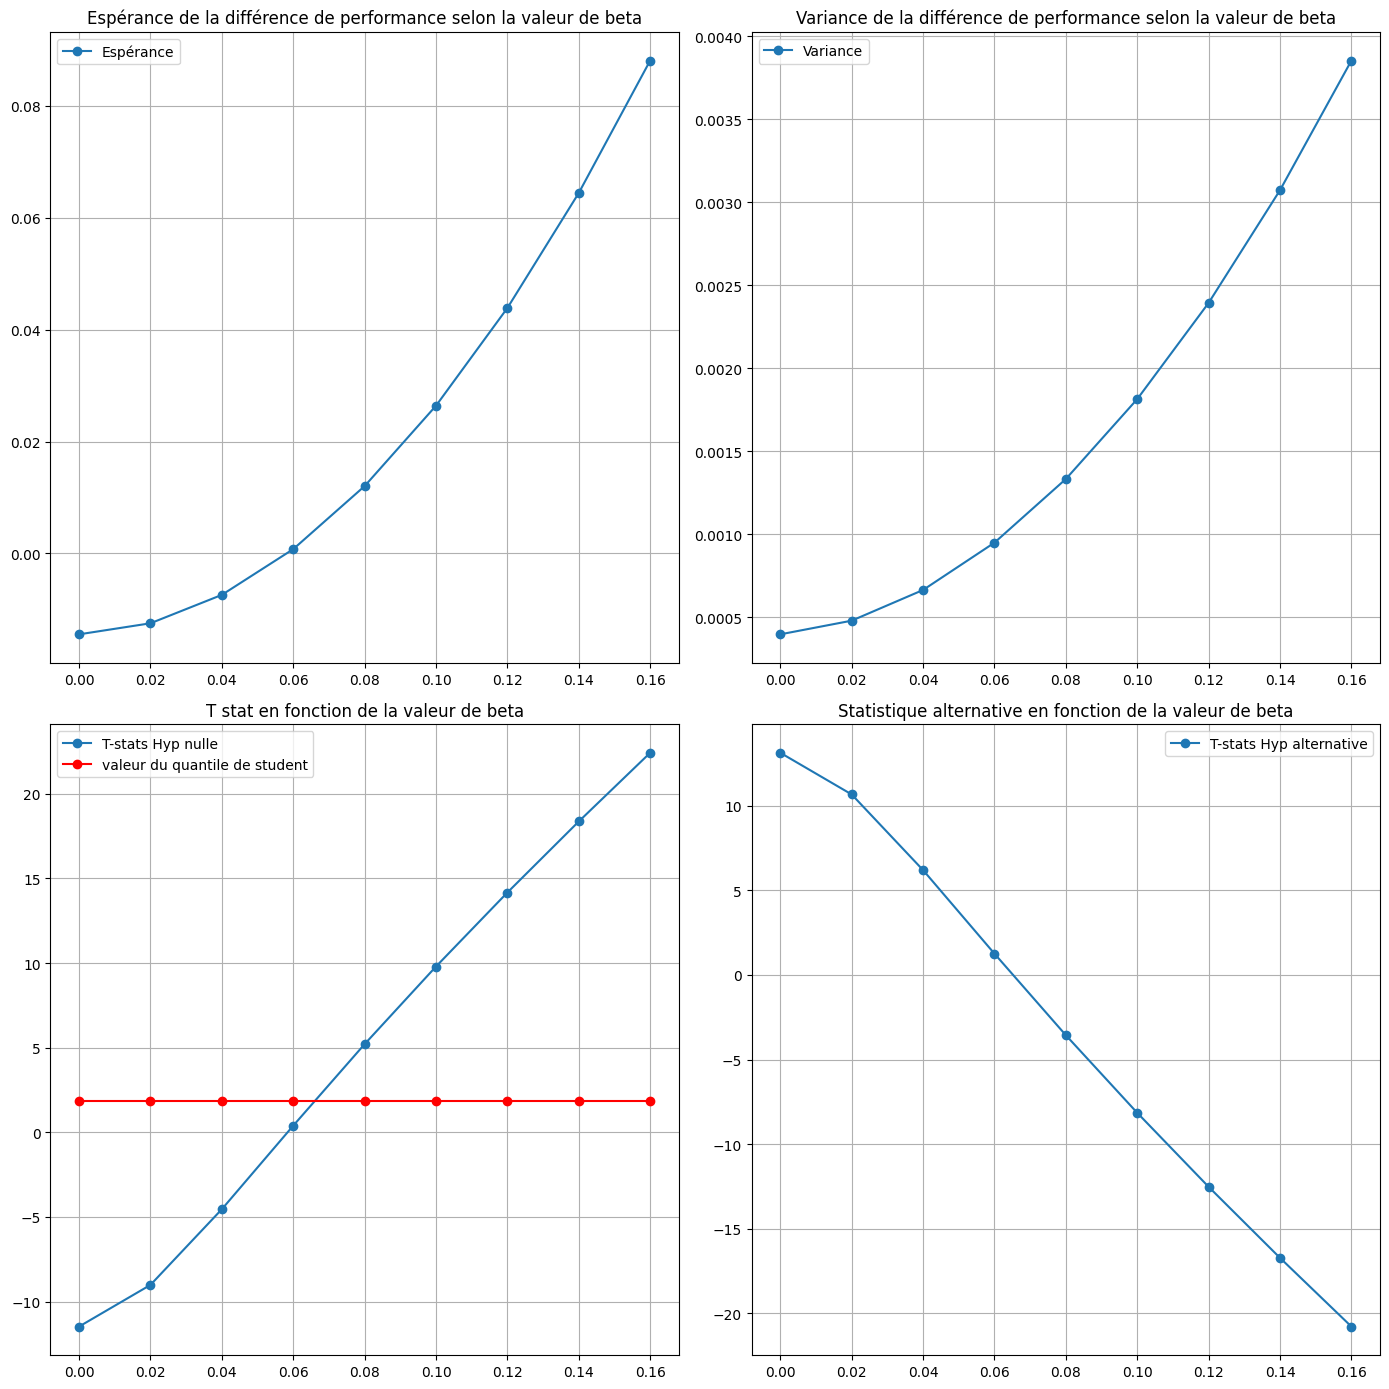

In [14]:
beta2_values = np.linspace(0, 0.16, 9)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

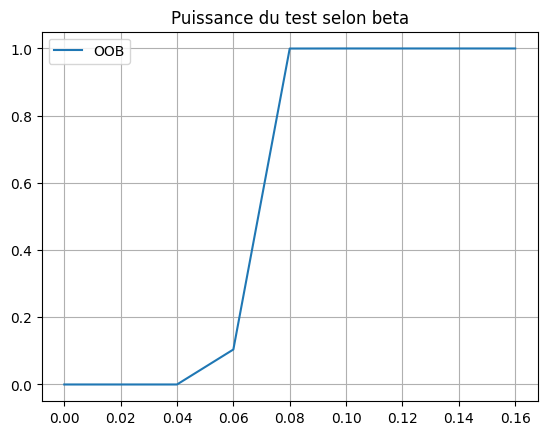

In [15]:
plt.figure()
plt.title("Puissance du test selon beta")
plt.plot(beta2_values, power, label = "OOB")
plt.grid()
plt.legend()
plt.show()

## Cross Validation Method

In [16]:
def power_RW_CV(n, B=250):
    np.random.seed(42)
    esperances = []
    variances = []
    test_statistics = []
    test_alternative = []
    power = []
    epsilon = np.random.normal(0, 1, n)
    x = np.random.uniform(0, 5, n)
    beta1 = 2
    beta2_values = np.linspace(0, 0.16, 9)
    
    # Generate bootstrap indices
    bootstrap_indices = np.random.choice(n, size=(B, n), replace=True)

    for beta2 in beta2_values:
        db = []

        for bootstrap_index in bootstrap_indices:
            # Generate data
            y = beta1 * x + beta2 * x**2 + epsilon

            x_train = x[bootstrap_index]
            y_train = beta1 * x_train + beta2 * x_train**2 + epsilon[bootstrap_index]
    
            # Cross-validation setup
            kf = KFold(n_splits=5)
            cv_scores_linear = []
            cv_scores_quadratic = []

            for train_index, test_index in kf.split(x_train):
                x_train_cv, x_test_cv = x_train[train_index], x_train[test_index]
                y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

                # Linear model
                model_a1 = LinearRegression().fit(x_train_cv.reshape(-1, 1), y_train_cv)
                y_pred_a1 = model_a1.predict(x_test_cv.reshape(-1, 1))
                mse_a1 = mean_squared_error(y_test_cv, y_pred_a1)
                cv_scores_linear.append(mse_a1)

                # Quadratic model
                x_train_cv_quad = np.column_stack((x_train_cv, x_train_cv**2))
                x_test_cv_quad = np.column_stack((x_test_cv, x_test_cv**2))
                model_a2 = LinearRegression().fit(x_train_cv_quad, y_train_cv)
                y_pred_a2 = model_a2.predict(x_test_cv_quad)
                mse_a2 = mean_squared_error(y_test_cv, y_pred_a2)
                cv_scores_quadratic.append(mse_a2)

            p1b = np.mean(cv_scores_linear)
            p2b = np.mean(cv_scores_quadratic)

            db.append(p1b - p2b)  # Difference in performance means for each bootstrap

        # End of bootstrapping
        d_barre = sum(db) / B  # Sample mean

        var = np.var(db, ddof=1)
        test_stat = (B**0.5) * d_barre / np.sqrt(var)  # Test statistic under null hypothesis

        delta = d_barre
        student = stats.t.ppf(0.95, df=B-1)
        mu = (B**0.5) * delta / np.sqrt(var)
        test_alt = student - mu
        puissance = 1 - stats.norm.cdf(student - mu, 0, 1)

        esperances.append(d_barre)
        variances.append(var)
        test_statistics.append(test_stat)
        test_alternative.append(test_alt)
        power.append(puissance)

    return esperances, variances, test_statistics, test_alternative, power


In [17]:
esperances_CV, variances_CV, test_statistics_CV, test_alternative_CV, power_CV = power_RW_CV(n=150, B=250)
print(f"Espérances: {esperances_CV}")
print(f"Variances: {variances_CV}")
print(f"Statistiques de test: {test_statistics_CV}")
print(f"Test alternative: {test_alternative_CV}")
print(f"Puissance: {power_CV}")


Espérances: [-0.006789758052747025, -0.005221996632950539, -0.000718843538060304, 0.006719701231923615, 0.01709363767700124, 0.030402965797172558, 0.0466476855924375, 0.0658277970627963, 0.08794330020824866]
Variances: [9.737544327025131e-05, 0.00012505024989822725, 0.00020740159268018527, 0.00034334216403051205, 0.0005321872616796752, 0.0007736547886742402, 0.001067865253376854, 0.001415341769466252, 0.0018170100559372563]
Statistiques de test: [-10.879265596175868, -7.383534522672515, -0.7892204569760938, 5.73398296505936, 11.715808410358667, 17.282730041083628, 22.570536266022444, 27.666145974899404, 32.620761730538234]
Test alternative: [12.530261747853128, 9.034530674349776, 2.4402166086533548, -4.082986813382099, -10.064812258681407, -15.631733889406366, -20.919540114345182, -26.015149823222142, -30.969765578860972]
Puissance: [0.0, 0.0, 0.007339228821043098, 0.9999777697266232, 1.0, 1.0, 1.0, 1.0, 1.0]


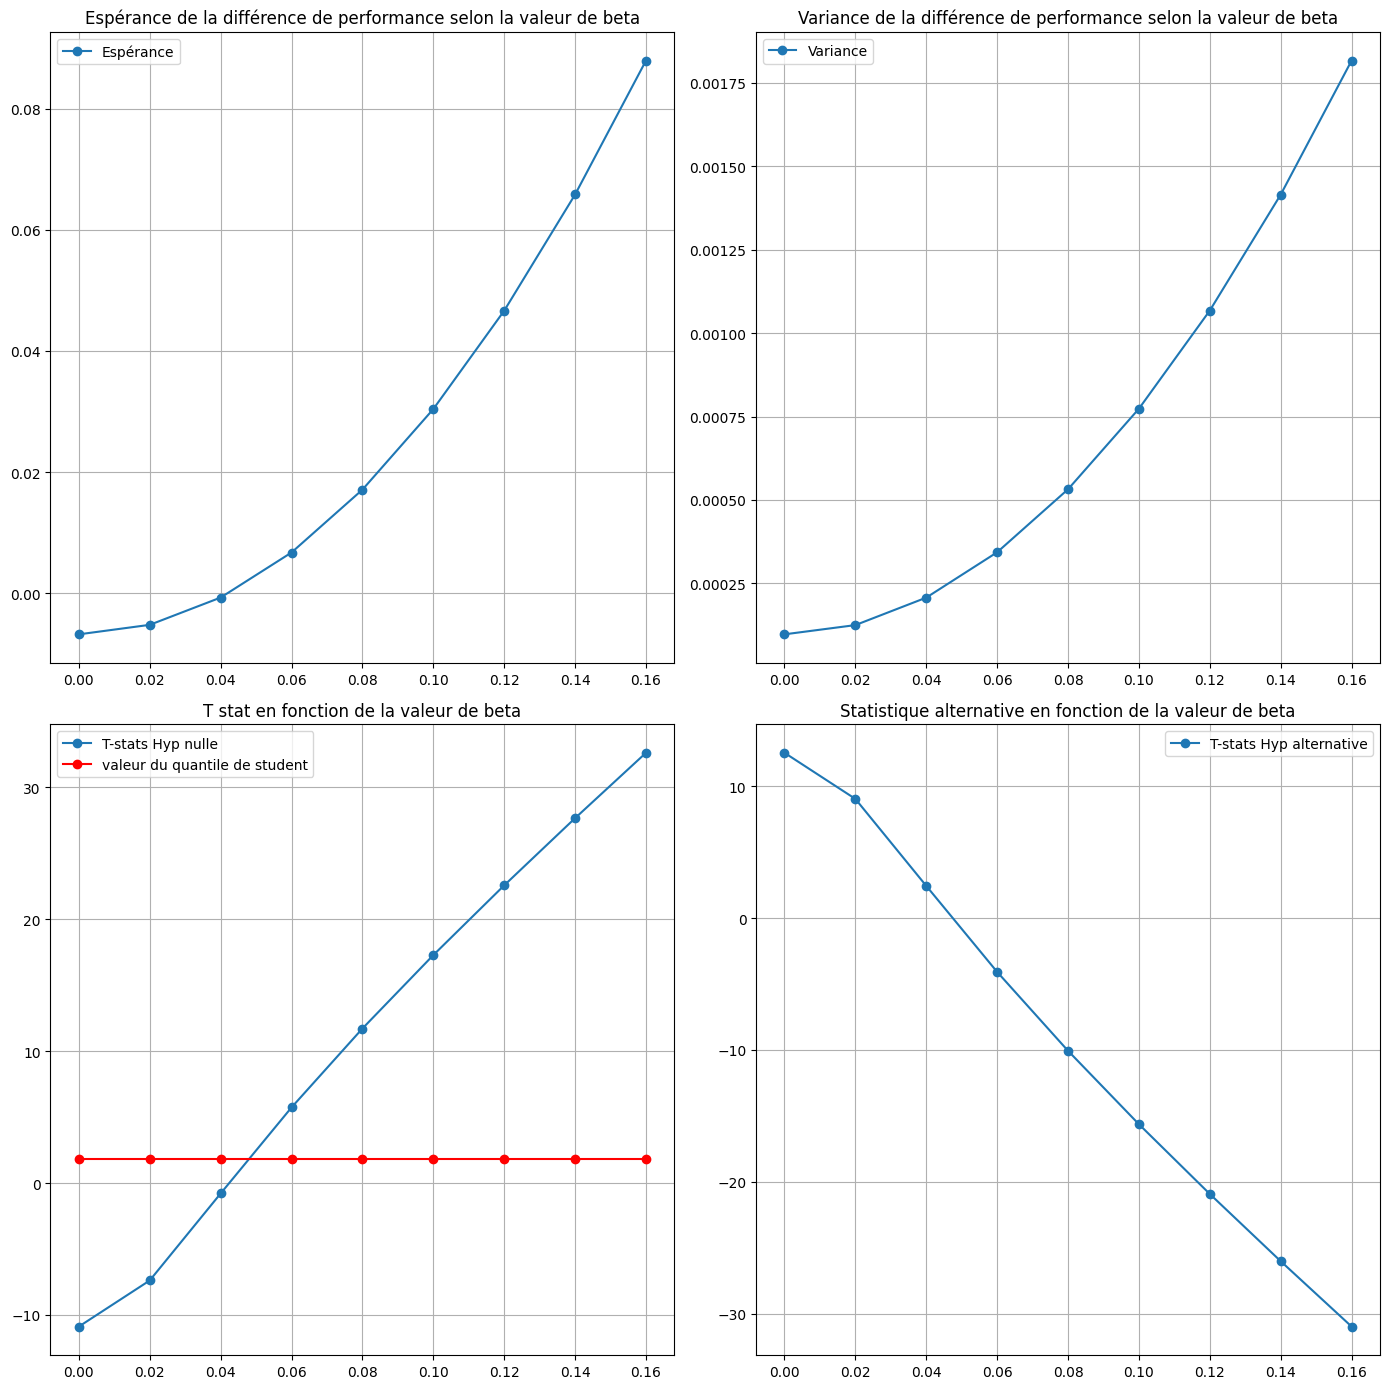

In [18]:
beta2_values = np.linspace(0, 0.16, 9)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances_CV, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances_CV, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics_CV, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative_CV, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

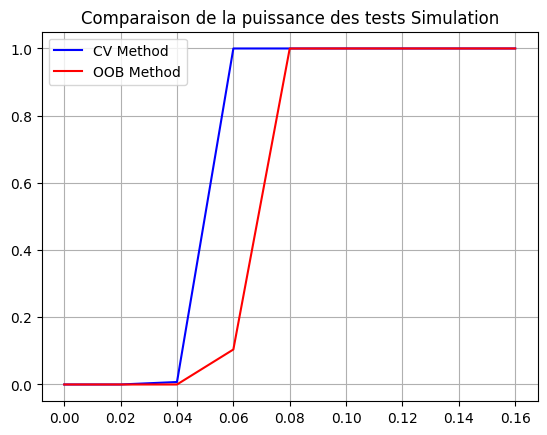

In [19]:
plt.figure()
plt.title("Comparaison de la puissance des tests Simulation")
plt.plot(beta2_values, power_CV, label = "CV Method", color = "Blue")
plt.plot(beta2_values, power, label = "OOB Method", color = "Red")
plt.grid()
plt.legend()
plt.show()

In [20]:
df_oob = pd.DataFrame(power)
df_cv = pd.DataFrame(power_CV)

## OOB - 2n 

In [22]:
def power_RW_OOB_2n(n,m=150,B=250):
        
   np.random.seed(42)

   esperances = []
   variances = []
   test_statistics = []
   test_alternative = []
   power = []

   epsilon_train = np.random.normal(0, 1, n)
   x_train = np.random.uniform(0, 5, n)

   epsilon_test = np.random.normal(0, 1, m)
   x_test = np.random.uniform(0, 5, m)

   x = np.concatenate((x_train, x_test))
   epsilon = np.concatenate((epsilon_train, epsilon_test)) 

   beta1 = 2
   beta2_values = np.linspace(0, 0.16, 9)

   bootstrap_indices = np.random.choice(n, size=(B, n), replace=True) # bootstrapping

   for beta2 in beta2_values:
       
       y = beta1 * x + beta2 * x**2 + epsilon # generation de données
       db = []
       
       for bootstrap_index in bootstrap_indices:
       
          x_train = x[bootstrap_index]
          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon[bootstrap_index]

          mask = np.ones(len(x), dtype=bool)
          mask[bootstrap_index] = False

          x_test = x[mask]
          y_test = y[mask]

          x_train_reshape = x_train.reshape(-1, 1)
          x_test_reshape = x_test.reshape(-1,1)

          model_a1 = LinearRegression().fit(x_train_reshape, y_train) # Modèle linéaire
          y_pred_a1 = model_a1.predict(x_test_reshape.reshape(-1,1))
          p1b = mean_squared_error(y_test, y_pred_a1)

          x_train_quad = np.column_stack((x_train_reshape, x_train**2))
          x_test_quad = np.column_stack((x_test_reshape, x_test**2))


          model_a2 = LinearRegression().fit(x_train_quad, y_train)
          y_pred_a2 = model_a2.predict(x_test_quad)
          p2b = mean_squared_error(y_test, y_pred_a2)

          db.append(p1b - p2b)  # Différence des moyennes de performance sur chaque bootstrap

       # Fin du boostrapping

       d_barre = sum(db)/B # Converge p.s vers l'espérance mu

       var = np.var(db, ddof=1)
       test_stat = (B**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle

       delta = d_barre
       student = stats.t.ppf(0.95, df=B-1)
       mu = (B ** 0.5)*delta/np.sqrt(var)
       test_alt = student - mu
       puissance = 1 - stats.norm.cdf(student - mu, 0, 1)
       
       esperances.append(d_barre)
       variances.append(var)
       test_statistics.append(test_stat)
       test_alternative.append(test_alt)
       power.append(puissance)

   return esperances, variances, test_statistics, test_alternative, power


Espérances: [-0.006789758052747025, -0.005221996632950539, -0.000718843538060304, 0.006719701231923615, 0.01709363767700124, 0.030402965797172558, 0.0466476855924375, 0.0658277970627963, 0.08794330020824866]
Variances: [9.737544327025131e-05, 0.00012505024989822725, 0.00020740159268018527, 0.00034334216403051205, 0.0005321872616796752, 0.0007736547886742402, 0.001067865253376854, 0.001415341769466252, 0.0018170100559372563]
Statistiques de test: [-10.879265596175868, -7.383534522672515, -0.7892204569760938, 5.73398296505936, 11.715808410358667, 17.282730041083628, 22.570536266022444, 27.666145974899404, 32.620761730538234]
Test alternative: [12.530261747853128, 9.034530674349776, 2.4402166086533548, -4.082986813382099, -10.064812258681407, -15.631733889406366, -20.919540114345182, -26.015149823222142, -30.969765578860972]
Puissance: [0.0, 0.0, 0.007339228821043098, 0.9999777697266232, 1.0, 1.0, 1.0, 1.0, 1.0]


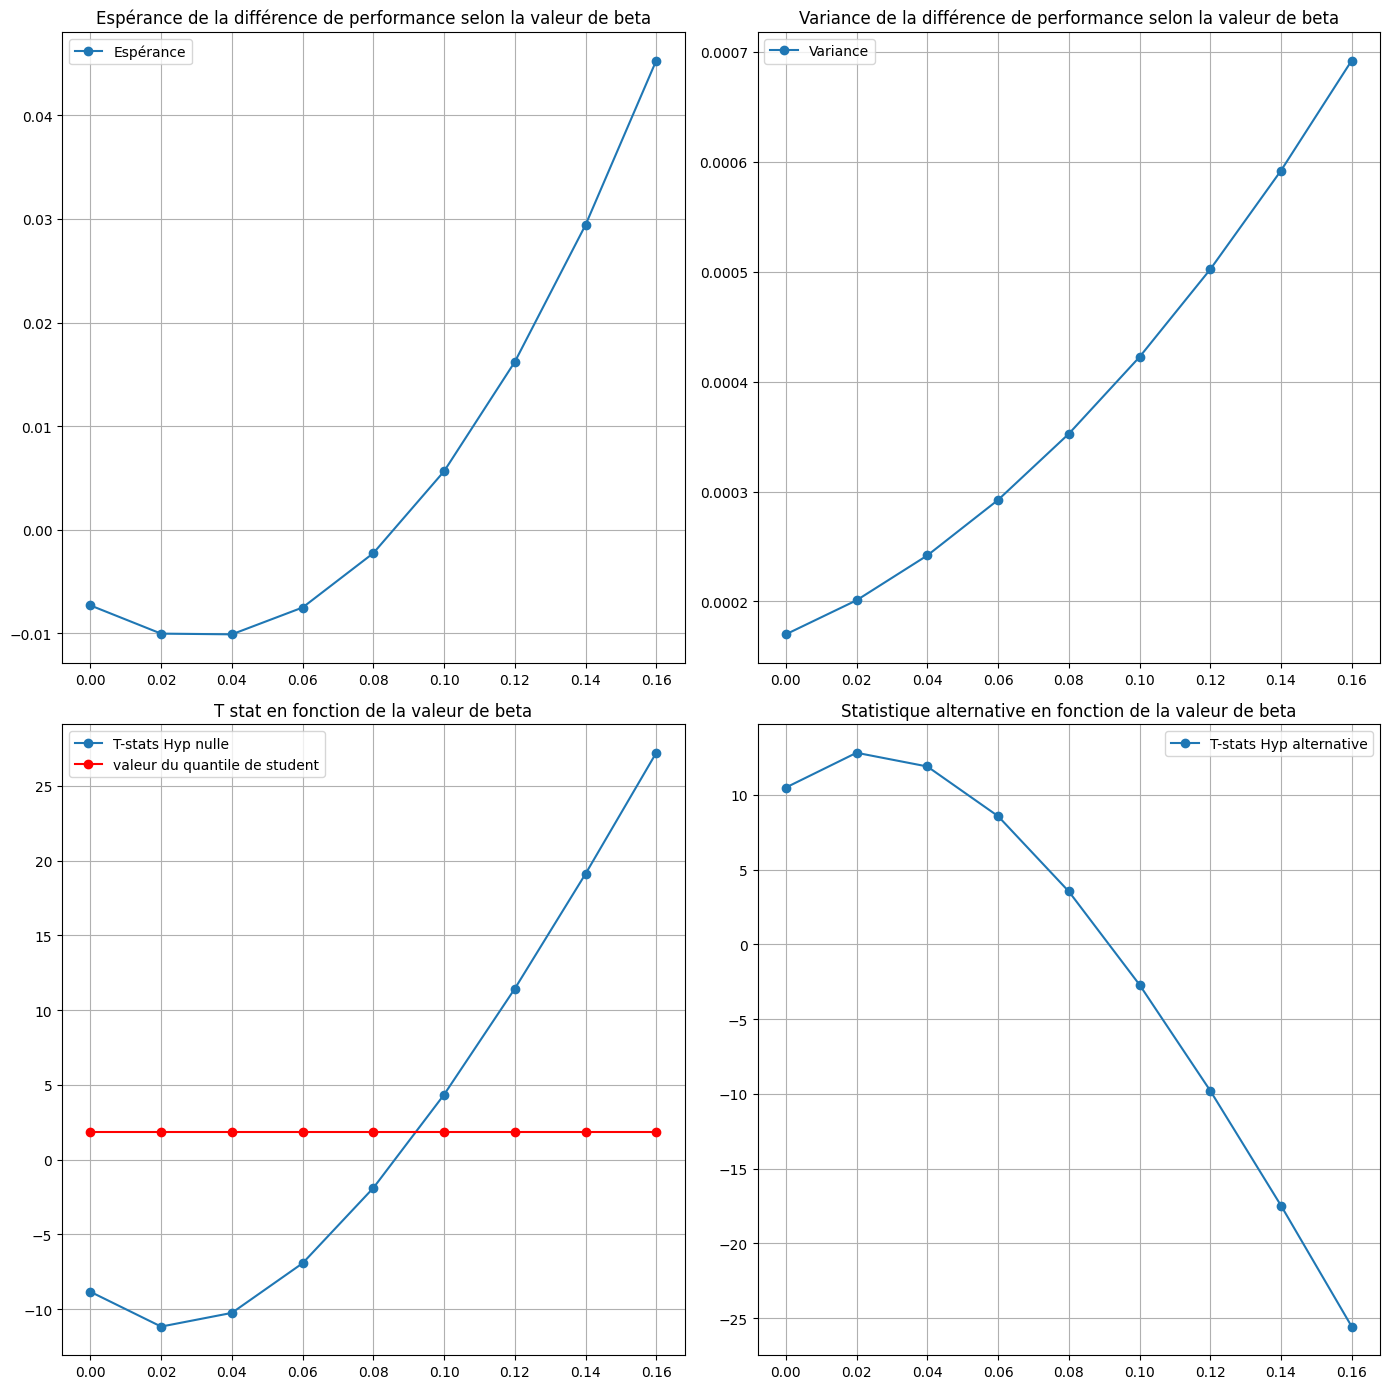

In [23]:
esperances_OBB2n, variances_OBB2n, test_statistics_OBB2n, test_alternative_OBB2n, power_OBB2n = power_RW_OOB_2n(n=150, B=250, m=150)
print(f"Espérances: {esperances_CV}")
print(f"Variances: {variances_CV}")
print(f"Statistiques de test: {test_statistics_CV}")
print(f"Test alternative: {test_alternative_CV}")
print(f"Puissance: {power_CV}")

beta2_values = np.linspace(0, 0.16, 9)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances_OBB2n, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances_OBB2n, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics_OBB2n, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative_OBB2n, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

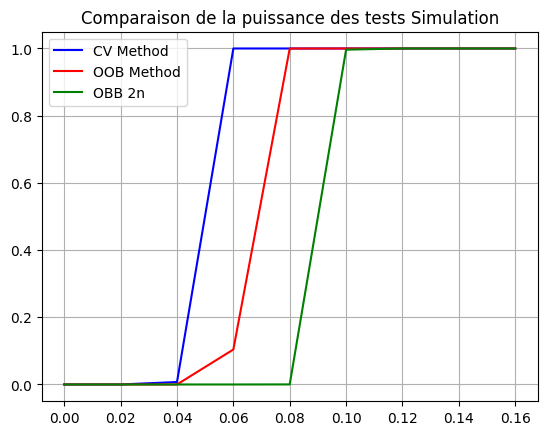

In [24]:
plt.figure()
plt.title("Comparaison de la puissance des tests Simulation")
plt.plot(beta2_values, power_CV, label = "CV Method", color = "Blue")
plt.plot(beta2_values, power, label = "OOB Method", color = "Red")
plt.plot(beta2_values, power_OBB2n, label = "OBB 2n", color = "Green")
plt.grid()
plt.legend()
plt.show()